In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn import tree, metrics
from pyscm import SetCoveringMachineClassifier
from randomscm.randomscm import RandomScmClassifier

from imblearn.under_sampling import RandomUnderSampler

1. Preparing data  
   Functions  
   Hyperparameters  
2. Random splitting (into train and test) and undersampling with randomized grid search to test several classifiers
3. Selecting best model and split
4. Performance metrics
5. Getting most important features

# 1. Preparing data

Filtering samples

In [2]:
path_to_metadata = "../../metadata/sordariomycetes_metadata_v2_21032023.csv"

# Filtering out samples
df_meta = pd.read_csv(path_to_metadata, sep=",")
df_meta = df_meta[(df_meta['buscoCS'] >= 85) & (df_meta['code'] != "BGRAM") & (df_meta['subsetOphio'] == 1)]
traits = ["code","AnyPathogen","effectors","assembly_length","genes","frac_repeats_dec","assembly_noreps","propGC",
            "N_introns","F_intron_genes","LEN_introns","LEN_exons","LEN_intergenic",
            "tRNA","pseudo_tRNA"]
df_meta = df_meta[traits]
df_meta.shape

(563, 15)

Adding matrix of distances

In [4]:
matrix = pd.read_csv('get_distances.tab', sep='\t', header=0)
#matrix = matrix.drop(columns='node')
df_meta_dist = pd.merge(df_meta, matrix, on='code', how='left')
print(df_meta_dist.shape, matrix.shape, df_meta.shape)
df_meta_dist = df_meta_dist.drop(columns="code")
df_meta_dist.head()

(563, 1140) (559, 1126) (563, 15)


,AnyPathogen,effectors,assembly_length,genes,frac_repeats_dec,assembly_noreps,propGC,N_introns,F_intron_genes,LEN_introns,...,NA.552,NA.553,NA.554,NA.555,NA.556,NA.557,NA.558,NA.559,NA.560,NA.561
0,1,103.0,49594594,6594,0.482322,25681092,0.416402,1.570670,0.705945,146.450420,...,0.867624,0.917250,0.993014,1.034116,1.066134,1.150582,1.075052,1.198607,1.124600,1.418945
1,0,182.0,28323031,8343,0.115887,25060361,0.553209,1.813376,0.752607,100.856567,...,0.765473,0.815099,0.890863,0.931965,0.963982,1.048430,0.972900,1.096455,1.022449,1.316794
2,1,386.0,35484800,10961,0.094336,32137302,0.530938,1.666545,0.711158,94.958614,...,0.851749,0.901375,0.977139,1.018241,1.050259,1.134707,1.059176,1.182732,1.108725,1.403070
3,0,269.0,31362364,9610,0.102075,28161037,0.566731,1.855775,0.737149,102.667489,...,0.721908,0.771534,0.847298,0.888400,0.920417,1.004866,0.929335,1.052891,0.978884,1.273229
4,1,84.0,27201902,6280,0.094069,24643057,0.463468,1.611783,0.788854,129.950010,...,1.094750,1.144376,1.220140,1.261242,1.293259,1.377708,1.302177,1.425733,1.351726,1.646071


Removing missing data

In [5]:
# Removing missing data
df_patho = df_meta_dist[df_meta_dist['AnyPathogen'] != "NAN"].reset_index(drop=True)
trait_values = {"1": 1, "0": 0}
df_patho['AnyPathogen'] = df_patho['AnyPathogen'].map(trait_values)
df_patho['AnyPathogen'].value_counts()
df_patho = df_patho.reset_index(drop=True)
print(df_patho.shape)
df_patho.head()

(559, 1139)


,AnyPathogen,effectors,assembly_length,genes,frac_repeats_dec,assembly_noreps,propGC,N_introns,F_intron_genes,LEN_introns,...,NA.552,NA.553,NA.554,NA.555,NA.556,NA.557,NA.558,NA.559,NA.560,NA.561
0,1,103.0,49594594,6594,0.482322,25681092,0.416402,1.570670,0.705945,146.450420,...,0.867624,0.917250,0.993014,1.034116,1.066134,1.150582,1.075052,1.198607,1.124600,1.418945
1,0,182.0,28323031,8343,0.115887,25060361,0.553209,1.813376,0.752607,100.856567,...,0.765473,0.815099,0.890863,0.931965,0.963982,1.048430,0.972900,1.096455,1.022449,1.316794
2,1,386.0,35484800,10961,0.094336,32137302,0.530938,1.666545,0.711158,94.958614,...,0.851749,0.901375,0.977139,1.018241,1.050259,1.134707,1.059176,1.182732,1.108725,1.403070
3,0,269.0,31362364,9610,0.102075,28161037,0.566731,1.855775,0.737149,102.667489,...,0.721908,0.771534,0.847298,0.888400,0.920417,1.004866,0.929335,1.052891,0.978884,1.273229
4,1,84.0,27201902,6280,0.094069,24643057,0.463468,1.611783,0.788854,129.950010,...,1.094750,1.144376,1.220140,1.261242,1.293259,1.377708,1.302177,1.425733,1.351726,1.646071


Split into X, y and scale data

In [6]:
scale_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

X = df_patho.iloc[:,1:].to_numpy()
y = df_patho.iloc[:,0].to_numpy()
X_norm = scale_pipeline.fit_transform(X)

np.count_nonzero(y==0), np.count_nonzero(y==1)

(200, 359)

# Functions

In [7]:
# A function to run the classifier for multiple random splits of the data into test and train
# with a grid search for each train dataset

def learn_splitting_GS(algo, data, targets, nbr_splits, params, test_size=0.2, n_jobs=1, proba=False, grid_search='randomized'):

    Output = {}
    bal_accs = []
    bal_accs_train = []
    preds = []
    preds_proba = []
    trues = []
    best_params = []
    
    for i in range(nbr_splits):
        if algo == "SVC":
            clf = SVC(random_state=42)        
        elif algo == "SCM":
            clf = SetCoveringMachineClassifier(random_state=42)
        elif algo == "DT":
            clf = DecisionTreeClassifier(random_state=42)
        elif algo == "RF":
            clf = RandomForestClassifier(random_state=42)
        elif algo == "rSCM":
            clf = RandomScmClassifier(random_state=42)
        elif algo == 'KNC':
            clf = KNeighborsClassifier()
        elif algo == 'GB':
            clf = GradientBoostingClassifier(random_state=42)
        
        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=test_size, random_state=i, stratify = targets)
        
        # Grid search & fit
        if grid_search == 'randomized':
            clf = RandomizedSearchCV(clf, param_distributions=params, scoring='balanced_accuracy', random_state=i, n_jobs=n_jobs)
        elif grid_search == 'grid':
            clf = GridSearchCV(clf, param_grid=params, scoring='balanced_accuracy', n_jobs=n_jobs)
        clf.fit(X_train, y_train)
        
        # Train accuracy
        y_pred_train = clf.predict(X_train)
        bal_accs_train.append(balanced_accuracy_score(y_train, y_pred_train))
        
        # Test accuracy
        y_pred = clf.predict(X_test)
        bal_accs.append(balanced_accuracy_score(y_test, y_pred))
        
        # Predicted probabilities
        if algo in ["DT", "RF", "rSCM"]:
            y_pred_proba = clf.predict_proba(X_test)
        else:
            y_pred_proba = clf.predict(X_test)          
            
        # Predicted and true values
        preds.append(y_pred)
        preds_proba.append(y_pred_proba)
        trues.append(y_test)

        
        # Best parameters from GS
        best_params.append(clf.best_params_)
        
    Output['balanced accuracy train'] = bal_accs_train
    Output['balanced accuracy test'] = bal_accs
    Output['predicted'] = preds
    Output['true'] = trues
    Output['best_params'] = best_params 
    
    if proba == True:
        Output['predicted proba'] = preds_proba
        return Output
    else:
        return Output

In [8]:
# A function to run the classifier for random splits of the data into test and train
# with subsequent subsampling each class from the train data up to a number corresponding to the count of the smaller class
# and a grid search on balanced train data

def learn_undersampling(algo, data, targets, nbr_splits, params, test_size=0.2, n_jobs=1, proba=False, grid_search='randomized'):
    
    Output = {}
    bal_accs = []
    bal_accs_train = []
    preds = []
    preds_proba = []
    trues = []
    best_params = []
    
    for i in range(nbr_splits):
        if algo == "SVC":
            clf = SVC(random_state=42)        
        elif algo == "SCM":
            clf = SetCoveringMachineClassifier(random_state=42)
        elif algo == "DT":
            clf = DecisionTreeClassifier(random_state=42)
        elif algo == "RF":
            clf = RandomForestClassifier(random_state=42)
        elif algo == "rSCM":
            clf = RandomScmClassifier(random_state=42)
        elif algo == 'KNC':
            clf = KNeighborsClassifier()
        elif algo == 'GB':
            clf = GradientBoostingClassifier(random_state=42)

        
        # Split into test and train
        X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=test_size, random_state=i, stratify = targets)
        
        # Subset of train with equally numbered classes
        rus = RandomUnderSampler(random_state=i)
        X_train_subsampled, y_train_subsampled = rus.fit_resample(X_train, y_train)
        
        # Fitting
        if grid_search == 'randomized':
            clf = RandomizedSearchCV(clf, param_distributions=params, n_jobs=n_jobs, random_state=i)
        elif grid_search == 'grid':
            clf = GridSearchCV(clf, param_grid=params, n_jobs=n_jobs)
        clf.fit(X_train_subsampled, y_train_subsampled)
        
        # Train score
        y_pred_train = clf.predict(X_train)
        bal_accs_train.append(balanced_accuracy_score(y_train, y_pred_train))
        
        # Test score
        y_pred = clf.predict(X_test)
        bal_accs.append(balanced_accuracy_score(y_test, y_pred))
        
        # Predicted probabilities
        if algo in ["DT", "RF", "rSCM"]:
            y_pred_proba = clf.predict_proba(X_test)
        else:
            y_pred_proba = clf.predict(X_test)
        
        # Predicted and true values
        preds.append(y_pred)
        trues.append(y_test)
        preds_proba.append(y_pred_proba)
        
        # Best parameters from GS
        best_params.append(clf.best_params_)
    
    
    Output['balanced accuracy train'] = bal_accs_train
    Output['balanced accuracy test'] = bal_accs
    Output['predicted'] = preds
    Output['true'] = trues
    Output['best_params'] = best_params
    
    if proba == True:
        Output['predicted proba'] = preds_proba
        return Output
    else:
        return Output
    

In [9]:
# A function to plot train and test accuracy from multiple repeats/splits of the data

def plot_classifier_scores(classifier_dfs, x = 'group', y = 'balanced accuracy', hue = 'set', title='', colors = ["#CADBC8","#679289"]):

    fig, ax = plt.subplots(1,1,figsize = (10,5))
    hue_order=['train','test']
    
    sns.barplot(data=classifier_dfs, x = x, y = y, hue = hue, estimator = np.mean, errorbar='sd', 
                dodge=True, hue_order=hue_order, palette=[colors[0], colors[1]], alpha=0.75, ax=ax)
    sns.stripplot(data=classifier_dfs, x = x, y = y, hue = hue, dodge=True, hue_order=hue_order, 
                  size=10, palette=[colors[0], colors[1]], edgecolor = "black", linewidth=1, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-2:], labels[-2:], loc=3)
    plt.xticks(rotation=90)
    plt.title(title)
    
    
# A function to identify an index of the best performing split from the output of learn_splitting_GS() or learn_undersampling() function

def find_best_split(output, column_name):
    best_split = pd.DataFrame(list(enumerate(output[column_name]))
                             ).sort_values(by=1, ascending=False).reset_index(drop=True).iloc[0,0]
    return(best_split)


# A function to retrain the estimator using the best split of data (random_state in the train_test_split), 
# and the best hyperparameters selected with Grid search

def retrain(algo, data_X, data_y, best_split_index, best_parameters_dict):

    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size = 0.2,
                                                        random_state = best_split_index,
                                                        stratify = data_y)

    rus = RandomUnderSampler(random_state = best_split_index)
    X_train_subsampled, y_train_subsampled = rus.fit_resample(X_train, y_train)

    if algo == "SVC":
        clf = SVC(random_state=42)        
    elif algo == "SCM":
        clf = SetCoveringMachineClassifier(random_state=42)
    elif algo == "DT":
        clf = DecisionTreeClassifier(random_state=42)
    elif algo == "RF":
        clf = RandomForestClassifier(random_state=42)
    elif algo == "rSCM":
        clf = RandomScmClassifier(random_state=42)

    clf.set_params(**best_parameters_dict)
    clf.fit(X_train_subsampled, y_train_subsampled)
    
    return(clf)


# A function to display confusion matrix as a heatmap
# List of labels to display (instead of sorted y labels) can be provided

def plotConfusionMatrix(true_labels, predicted_labels, labels_to_display=False):
    
    labels_uniq = list(set(true_labels))
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels = labels_uniq, normalize="true")
    
    if labels_to_display:
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels_to_display)
    else:
        labels_to_display = labels_uniq
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels_to_display)

    cm_display.plot()
    plt.show()


# A function to create a data frame of features and their importances, given as lists,
# sort them according to importance, and select the top x features with most importance

def selectTopFeatures(feature_list, importance_list, top_n):
    df = pd.DataFrame({'feature' : feature_list, 'importance' : importance_list})
    df_sorted_top = df.sort_values(by = 'importance', ascending = False).reset_index(drop=True).head(top_n)
    return(df_sorted_top)

# Hyperparameters

In [10]:
# List of parameters for grid search
hyperparameters_rf = {'max_features' : [i/10 for i in range(2, 10, 1)],
                 'max_depth' : range(2,12)}

hyperparameters_gb = {'max_features' : [i/10 for i in range(2, 10, 1)],
              'max_depth' : range(2,20,1)}

hyperparameters_dt = {'max_depth': range(1,20,1),
                 'max_features':[i/10 for i in range(1, 10, 1)]}

hyperparameters_svc = {'C':[0.01, 0.1, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101],
                  'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

hyperparameters_scm = {'max_rules': range(2,12),
                  'model_type':["conjunction","disjunction"],
                  'p':[i/10 for i in range(5, 22, 1)]}

hyperparameters_rscm = {'max_rules':  range(1,20,1),
                   'max_features' : [i/10 for i in range(2, 10, 1)],
                   'model_type':["conjunction","disjunction"]}

hyperparameters_kn = {'n_neighbors':range(1,15,1),
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'weights' : ['uniform', 'distance']}

# 2. Testing several classifiers

## Random splitting

In [11]:
print('SVC')
out_SVC = learn_splitting_GS("SVC", X_norm, y, 10, hyperparameters_svc, n_jobs=10, grid_search='randomized')
out_SVC_df = pd.DataFrame({'train' : out_SVC['balanced accuracy train'],
                           'test' : out_SVC['balanced accuracy test']}).stack().reset_index()
out_SVC_df.columns = ['split', 'set', 'balanced accuracy']
out_SVC_df['group'] = 'SVC'

#print('SCM')
#out_SCM = learn_splitting_GS("SCM", X_norm, y, 10, hyperparameters_scm, n_jobs=10, grid_search='randomized')
#out_SCM_df = pd.DataFrame({'train' : out_SCM['balanced accuracy train'],
#                           'test' : out_SCM['balanced accuracy test']}).stack().reset_index()
#out_SCM_df.columns = ['split', 'set', 'balanced accuracy']
#out_SCM_df['group'] = 'SCM'

print('K Neighbors')
out_KNC = learn_splitting_GS("KNC", X, y, 10, hyperparameters_kn, n_jobs=10, grid_search='randomized')
out_KNC_df = pd.DataFrame({'train' : out_KNC['balanced accuracy train'],
                           'test' : out_KNC['balanced accuracy test']}).stack().reset_index()
out_KNC_df.columns = ['split', 'set', 'balanced accuracy']
out_KNC_df['group'] = 'KNC'

print('Decision Tree')
out_DT = learn_splitting_GS("DT", X, y, 10, hyperparameters_dt, n_jobs=10, grid_search='randomized')
out_DT_df = pd.DataFrame({'train' : out_DT['balanced accuracy train'],
                           'test' : out_DT['balanced accuracy test']}).stack().reset_index()
out_DT_df.columns = ['split', 'set', 'balanced accuracy']
out_DT_df['group'] = 'Decision Tree'

print('Random Forest')
out_RF = learn_splitting_GS("RF", X, y, 10, hyperparameters_rf, n_jobs=10, grid_search='randomized')
out_RF_df = pd.DataFrame({'train' : out_RF['balanced accuracy train'],
                           'test' : out_RF['balanced accuracy test']}).stack().reset_index()
out_RF_df.columns = ['split', 'set', 'balanced accuracy']
out_RF_df['group'] = 'Random Forest'

#print('Random SCM')
#out_rSCM = learn_splitting_GS("rSCM", X, y, 10, hyperparameters_rscm, n_jobs=10, grid_search='randomized')
#out_rSCM_df = pd.DataFrame({'train' : out_rSCM['balanced accuracy train'],
#                             'test' : out_rSCM['balanced accuracy test']}).stack().reset_index()
#out_rSCM_df.columns = ['split', 'set', 'balanced accuracy']
#out_rSCM_df['group'] = 'random SCM'

print('Gradient Boosting')
out_GB = learn_splitting_GS("GB", X, y, 10, hyperparameters_gb, n_jobs=10, grid_search='randomized')
out_GB_df = pd.DataFrame({'train' : out_GB['balanced accuracy train'],
                             'test' : out_GB['balanced accuracy test']}).stack().reset_index()
out_GB_df.columns = ['split', 'set', 'balanced accuracy']
out_GB_df['group'] = 'GB'


#DF = pd.concat([out_SVC_df, out_SCM_df, out_DT_df, out_RF_df, out_rSCM_df], ignore_index=True)
DF = pd.concat([out_SVC_df, out_KNC_df, out_DT_df, out_RF_df, out_GB_df], ignore_index=True)
DF.to_csv('ml_classification_pathogens_with_phylogeny_learn_random_splitting.tsv', sep = '\t', header=True)

SVC
K Neighbors
Decision Tree
Random Forest
Gradient Boosting


mean_BS
group         set            
Decision Tree test   0.687639
              train  0.899567
GB            test   0.713472
              train  0.970968
KNC           test   0.556111
              train  0.787546
Random Forest test   0.724306
              train  0.913601
SVC           test   0.715278
              train  0.810057

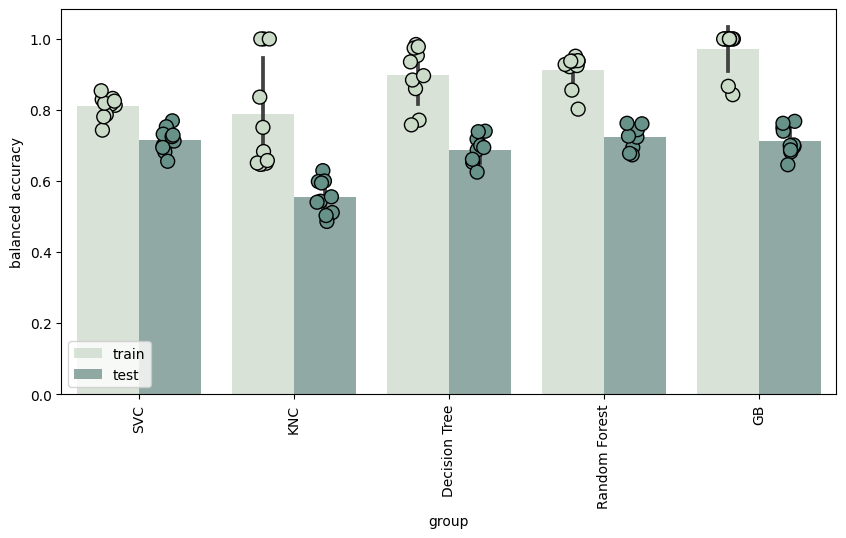

In [12]:
# Plotting
plot_classifier_scores(DF, x = 'group', y = 'balanced accuracy', hue = 'set')
DF.groupby(['group','set']).agg(mean_BS = ('balanced accuracy', 'mean'))

## Undersampling

In [13]:
print('SVC')
out_SVC = learn_undersampling("SVC", X_norm, y, 10, hyperparameters_svc, n_jobs=10, grid_search='randomized')
out_SVC_df = pd.DataFrame({'train' : out_SVC['balanced accuracy train'],
                           'test' : out_SVC['balanced accuracy test']}).stack().reset_index()
out_SVC_df.columns = ['split', 'set', 'balanced accuracy']
out_SVC_df['group'] = 'SVC'

#print('SCM')
#out_SCM = learn_undersampling("SCM", X_norm, y, 10, hyperparameters_scm, n_jobs=10, grid_search='randomized')
#out_SCM_df = pd.DataFrame({'train' : out_SCM['balanced accuracy train'],
#                           'test' : out_SCM['balanced accuracy test']}).stack().reset_index()
#out_SCM_df.columns = ['split', 'set', 'balanced accuracy']
#out_SCM_df['group'] = 'SCM'

print('K Neighbors')
out_KNC = learn_undersampling("KNC", X, y, 10, hyperparameters_kn, n_jobs=10, grid_search='randomized')
out_KNC_df = pd.DataFrame({'train' : out_KNC['balanced accuracy train'],
                           'test' : out_KNC['balanced accuracy test']}).stack().reset_index()
out_KNC_df.columns = ['split', 'set', 'balanced accuracy']
out_KNC_df['group'] = 'KNC'

print('Decision Tree')
out_DT = learn_undersampling("DT", X, y, 10, hyperparameters_dt, n_jobs=10, grid_search='randomized')
out_DT_df = pd.DataFrame({'train' : out_DT['balanced accuracy train'],
                           'test' : out_DT['balanced accuracy test']}).stack().reset_index()
out_DT_df.columns = ['split', 'set', 'balanced accuracy']
out_DT_df['group'] = 'Decision Tree'

print('Random Forest')
out_RF = learn_undersampling("RF", X, y, 10, hyperparameters_rf, n_jobs=10, grid_search='randomized')
out_RF_df = pd.DataFrame({'train' : out_RF['balanced accuracy train'],
                           'test' : out_RF['balanced accuracy test']}).stack().reset_index()
out_RF_df.columns = ['split', 'set', 'balanced accuracy']
out_RF_df['group'] = 'Random Forest'

#print('Random SCM')
#out_rSCM = learn_splitting_GS("rSCM", X, y, 10, hyperparameters_rscm, n_jobs=10, grid_search='randomized')
#out_rSCM_df = pd.DataFrame({'train' : out_rSCM['balanced accuracy train'],
#                             'test' : out_rSCM['balanced accuracy test']}).stack().reset_index()
#out_rSCM_df.columns = ['split', 'set', 'balanced accuracy']
#out_rSCM_df['group'] = 'random SCM'

print('Gradient Boosting')
out_GB = learn_undersampling("GB", X, y, 10, hyperparameters_gb, n_jobs=10, grid_search='randomized')
out_GB_df = pd.DataFrame({'train' : out_GB['balanced accuracy train'],
                             'test' : out_GB['balanced accuracy test']}).stack().reset_index()
out_GB_df.columns = ['split', 'set', 'balanced accuracy']
out_GB_df['group'] = 'GB'


#DF = pd.concat([out_SVC_df, out_SCM_df, out_DT_df, out_RF_df, out_rSCM_df], ignore_index=True)
DUS = pd.concat([out_SVC_df, out_KNC_df, out_DT_df, out_RF_df, out_GB_df], ignore_index=True)
DUS.to_csv('ml_classification_pathogens_with_phylogeny_learn_undersampling.tsv', sep = '\t', header=True)

SVC
K Neighbors
Decision Tree
Random Forest
Gradient Boosting


mean_BS
group         set            
Decision Tree test   0.673056
              train  0.862648
GB            test   0.708750
              train  0.920139
KNC           test   0.582778
              train  0.662472
Random Forest test   0.711944
              train  0.893428
SVC           test   0.705278
              train  0.794329

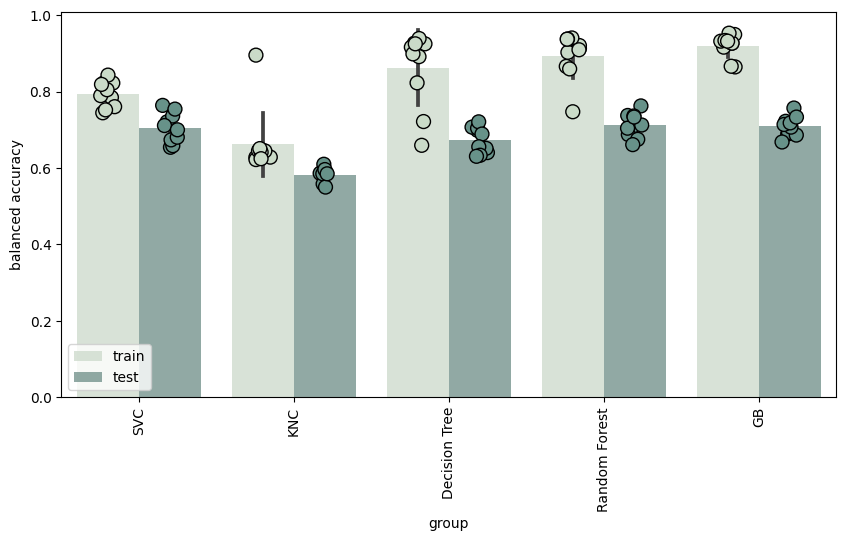

In [14]:
# Undersampling
plot_classifier_scores(DUS, x = 'group', y = 'balanced accuracy', hue = 'set')
DUS.groupby(['group','set']).agg(mean_BS = ('balanced accuracy', 'mean'))

# 3. Selecting best model and split

## Finding best parameters and best split

In [15]:
# Rerunning Random Forest with full grid search
out_best = learn_splitting_GS("RF", X, y, 10, hyperparameters_rf, n_jobs=10, proba=True, grid_search='grid')
# Finding best split
best_split = find_best_split(out_best, 'balanced accuracy test')
print("Best split: %d" %best_split)
print("Best split balanced accuracy: %.2f" %out_best['balanced accuracy test'][best_split])

Best split: 5
Best split balanced accuracy: 0.76


In [16]:
np.mean(out_best['balanced accuracy test'])

0.7251388888888889

In [17]:
out_best['best_params'][best_split]

{'max_depth': 11, 'max_features': 0.3}

In [18]:
out_best.keys()
#out_best['true']

dict_keys(['balanced accuracy train', 'balanced accuracy test', 'predicted', 'true', 'best_params', 'predicted proba'])

# 4. Performance metrics

All metrics for all splits

In [19]:
precision_score = []
recall_score = []
f1_score = []
roc_auc_score = []
balanced_accuracy_score = []
accuracy_score = []
for split in range(10):
    precision_score.append(metrics.precision_score(out_best['true'][split], out_best['predicted'][split]))
    recall_score.append(metrics.recall_score(out_best['true'][split], out_best['predicted'][split]))
    f1_score.append(metrics.f1_score(out_best['true'][split], out_best['predicted'][split]))
    roc_auc_score.append(metrics.roc_auc_score(out_best['true'][split], out_best['predicted'][split]))
    balanced_accuracy_score.append(metrics.balanced_accuracy_score(out_best['true'][split], out_best['predicted'][split]))
    accuracy_score.append(metrics.accuracy_score(out_best['true'][split], out_best['predicted'][split]))
dMets = pd.DataFrame({'split' : list(range(10)),
                         'precision_score' : precision_score,
                        'recall_score' : recall_score,
                        'f1_score' : f1_score,
                        'roc_auc_score' : roc_auc_score,
                        'balanced_accuracy_score' : balanced_accuracy_score,
                        'accuracy_score' : accuracy_score})

dMets.to_csv('ml_classification_pathogens_with_phylogeny_metrics.tsv', sep='\t', header=True)
dMets

,split,precision_score,recall_score,f1_score,roc_auc_score,balanced_accuracy_score,accuracy_score
0,0,0.761905,0.888889,0.820513,0.694444,0.694444,0.750000
1,1,0.804878,0.916667,0.857143,0.758333,0.758333,0.803571
2,2,0.781609,0.944444,0.855346,0.734722,0.734722,0.794643
3,3,0.744186,0.888889,0.810127,0.669444,0.669444,0.732143
4,4,0.773810,0.902778,0.833333,0.713889,0.713889,0.767857
5,5,0.818182,0.875000,0.845638,0.762500,0.762500,0.794643
6,6,0.821918,0.833333,0.827586,0.754167,0.754167,0.776786
7,7,0.764706,0.902778,0.828025,0.701389,0.701389,0.758929
8,8,0.771084,0.888889,0.825806,0.706944,0.706944,0.758929
9,9,0.815789,0.861111,0.837838,0.755556,0.755556,0.785714


In [20]:
dMets.describe()

,split,precision_score,recall_score,f1_score,roc_auc_score,balanced_accuracy_score,accuracy_score
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.50000,0.785807,0.890278,0.834136,0.725139,0.725139,0.772321
std,3.02765,0.027370,0.030323,0.015046,0.032357,0.032357,0.022763
min,0.00000,0.744186,0.833333,0.810127,0.669444,0.669444,0.732143
25%,2.25000,0.766300,0.878472,0.826251,0.702778,0.702778,0.758929
50%,4.50000,0.777709,0.888889,0.830679,0.724306,0.724306,0.772321
75%,6.75000,0.813062,0.902778,0.843688,0.755208,0.755208,0.792411
max,9.00000,0.821918,0.944444,0.857143,0.762500,0.762500,0.803571


Performance of the best split

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        40
           1       0.82      0.88      0.85        72

    accuracy                           0.79       112
   macro avg       0.78      0.76      0.77       112
weighted avg       0.79      0.79      0.79       112



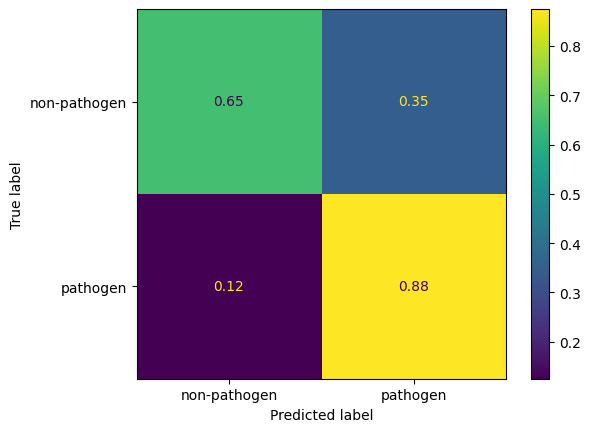

In [21]:
# Classification report for the best split
print(classification_report(out_best['true'][best_split], out_best['predicted'][best_split]))

# Confusion matrix for the best split
plotConfusionMatrix(out_best['true'][best_split],
                         out_best['predicted'][best_split], 
                         labels_to_display = ["non-pathogen", "pathogen"])

ROC curves

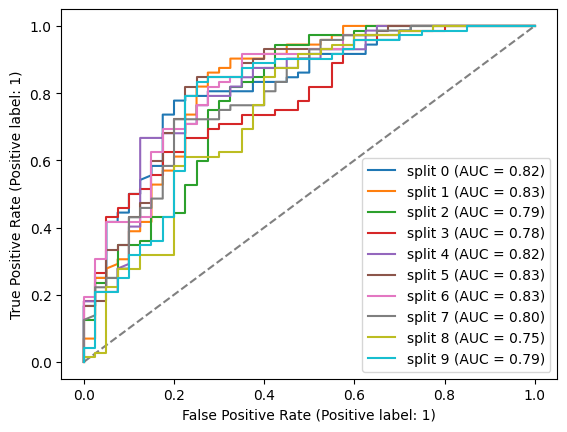

In [22]:
ax = plt.gca()
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
for split in range(10):
    roc_best_disp = RocCurveDisplay.from_predictions(out_best['true'][split],
                                                     out_best['predicted proba'][split][:,1],
                                                     name = "split " + str(split), ax=ax)

# 5. Getting most important features

## Retraining the model and split with best parameters

In [23]:
#best_split = 5
#best_params = {'max_depth': 11, 'max_features': 0.3}

In [24]:
clf_rf2 = retrain("RF", X, y, best_split, out_best['best_params'][best_split])
clf_rf2

RandomForestClassifier(max_depth=11, max_features=0.3, random_state=42)

## Getting feature names

In [25]:
features = df_patho.columns.values[1:]
features

array(['effectors', 'assembly_length', 'genes', ..., 'NA.559', 'NA.560',
       'NA.561'], dtype=object)

## Feature importances

In [26]:
# Getting feature importances
feature_importances = clf_rf2.feature_importances_
len(feature_importances)

# Sorting features
feats_rf2 = selectTopFeatures(features, feature_importances, 20)
feats_rf2.to_csv('ml_classification_pathogens_with_phylogeny_feature_importances.tsv', sep='\t', header=True)
feats_rf2

,feature,importance
0,tRNA,0.037114
1,N_introns,0.025034
2,genes,0.022092
3,effectors,0.021433
4,propGC,0.019094
5,LEN_introns,0.017812
6,frac_repeats_dec,0.017078
7,F_intron_genes,0.016919
8,pseudo_tRNA,0.016364
9,LEN_intergenic,0.015741


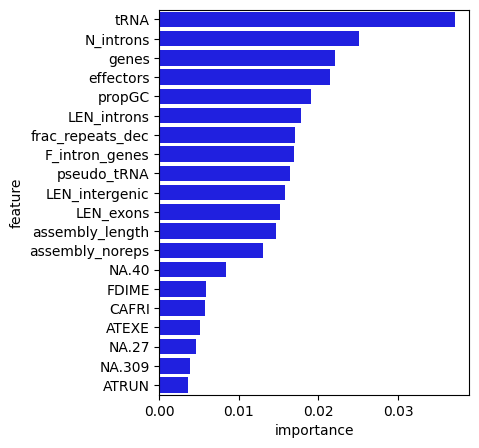

In [27]:
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(data = feats_rf2, y = 'feature', x = 'importance', ax=ax, color="blue")
plt.show()

## Feature importances from all splits

In [28]:
F = []
for split in range(10):
    clf_rf_ = retrain("RF", X, y, split, out_best['best_params'][split])
    feature_importances_ = clf_rf_.feature_importances_
    feature_importances_sorted = selectTopFeatures(features, feature_importances_, 20)
    feature_importances_sorted['split'] = split
    F.append(feature_importances_sorted)
dF = pd.concat(F, ignore_index=True)
dF.head()

,feature,importance,split
0,effectors,0.056731,0
1,genes,0.036855,0
2,tRNA,0.034719,0
3,N_introns,0.021098,0
4,F_intron_genes,0.019433,0


In [29]:
dF.to_csv('ml_classification_pathogens_with_phylogeny_feature_importances_all_splits.tsv', sep='\t', header=True)

In [30]:
dF.groupby('feature').agg(mean = ('importance','mean'),
                         sem = ('importance', 'sem')).reset_index().sort_values(by = 'mean', ascending = False)

,feature,mean,sem
64,effectors,0.060047,0.008079
66,genes,0.030649,0.002667
69,tRNA,0.029330,0.002669
21,F_intron_genes,0.020449,0.002673
54,N_introns,0.020184,0.003370
...,...,...,...
36,NA.2,0.003888,NaN
40,NA.294,0.003864,NaN
35,NA.162,0.003804,NaN
13,DEUCA,0.003597,NaN
